# Unsupervised Learning Approach - PCA and tSNE for Visualization 

In [1]:
# Imports
from sklearn.manifold import TSNE
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.decomposition import PCA
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Read data
data = pd.read_csv("business-licences-hackathon.csv", sep=";")

/Users/elabandari/opt/miniconda3/envs/563/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3155: DtypeWarning: Columns (13) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


## Preprocess Data 

In [3]:
# Drop columns not of interest
data_to_use = data.drop(
    columns=[
        "BusinessType",
        "ExpiredDate",
        "Geom",
        "ExtractDate",
        "Province",
        "LicenceNumber",
        "LicenceRSN",
        "FOLDERYEAR",
        "UnitType",
        "House",
        "IssuedDate",
        "Country",
        "PostalCode",
        "City",
    ]
)
# Change business name and trade name to binary
data_to_use["BusinessTradeName"] = data_to_use["BusinessTradeName"].notna()
data_to_use["BusinessName"] = data_to_use["BusinessName"].notna()
data_to_use["BusinessSubType"] = data_to_use["BusinessSubType"].notna()
data_to_use["Unit"] = data_to_use["Unit"].notna()
data_to_use["Street"] = data_to_use["Street"].notna()

# Change labels for Status
dict = {
    "Gone Out of Business": 1,
    "Cancelled": 2,
    "Inactive": 3,
    "Pending": 4,
    "Issued": 5,
}
data_to_use["Status"] = data_to_use["Status"].map(dict)

# Define Data types
categorical = ["LocalArea"]
numeric = ["NumberofEmployees", "FeePaid"]
pass_feat = [
    "Status",
    "LicenceRevisionNumber",
    "BusinessName",
    "Street",
    "BusinessTradeName",
    "BusinessSubType",
    "Unit",
]

# Make column transformer
categorical_transformer = make_pipeline(
    OneHotEncoder(handle_unknown="ignore"),
)
numeric_transformer = make_pipeline(SimpleImputer(strategy="mean"), StandardScaler())

preprocessor = make_column_transformer(
    (numeric_transformer, numeric),
    (categorical_transformer, categorical),
    ("passthrough", pass_feat),
)

# Transform data
transformed_data = preprocessor.fit_transform(data_to_use)
pd.DataFrame(transformed_data)

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,-0.001876,-0.061235,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,5,0,True,True,True,False,False
1,-0.001876,-0.218217,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,5,0,True,True,True,True,True
2,-0.001875,-0.218217,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,5,0,True,True,False,True,False
3,-0.001876,-0.312168,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,2,0,True,True,False,True,True
4,-0.001876,-0.299086,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,5,0,True,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
569022,-0.001876,-0.188485,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,4,0,True,True,True,False,False
569023,-0.001876,-0.095723,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,5,0,True,False,True,False,False
569024,-0.001876,-0.188485,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,5,0,True,True,True,False,False
569025,-0.001876,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,4,0,True,False,False,False,False


## Use PCA Reduce Dimensionality

In [4]:
pca = PCA()
pca.fit(transformed_data)

PCA()

In [5]:
# Determine explained variance to reduce dimensionality 
var_exp = np.cumsum(pca.explained_variance_ratio_)
pd.DataFrame(var_exp).head(10)

,0
0,0.250834
1,0.445484
2,0.638054
3,0.727520
4,0.776677
5,0.812589
6,0.840610
7,0.859262
8,0.873932
9,0.886612


 > The first 6 features explain a good amount of variability.

### Plot first two Principal Components

In [6]:
# Plotting helper function adapted from UBC DSCI 563
def plot_pca_clusters(
    data,
    cluster_labels,
    raw_rows=None,
    show_labels=False,
    size=100,
    title="PCA visualization",
):
    """
    Carry out dimensionality reduction using PCA and plot 2-dimensional clusters.
    Parameters
    -----------
    data : numpy array
        data as a numpy array
    cluster_labels : list
        cluster labels for each row in the dataset
    raw_rows : list
        the original raw sentences for labeling datapoints
    show_labels : boolean
        whether you want to show labels for points or not (default: False)
    size : int
        size of points in the scatterplot
    title : str
        title for the visualization plot
    Returns
    -----------
    None. Shows the clusters.
    """
    pca = PCA(n_components=2)
    principal_comp = pca.fit_transform(data)
    pca_df = pd.DataFrame(data=principal_comp, columns=["pca1", "pca2"])
    pca_df["cluster"] = cluster_labels
    plt.figure(figsize=(10, 7))
    plt.title(title)
    ax = sns.scatterplot(
        x="pca1", y="pca2", hue="cluster", data=pca_df, palette="tab10", s=size
    )
    x = pca_df["pca1"].tolist()
    y = pca_df["pca2"].tolist()
    if show_labels:
        for i, txt in enumerate(raw_rows):
            plt.annotate(" ".join(txt.split()[:10]), (x[i], y[i]))
        ax.legend(loc="upper left")
    plt.show()

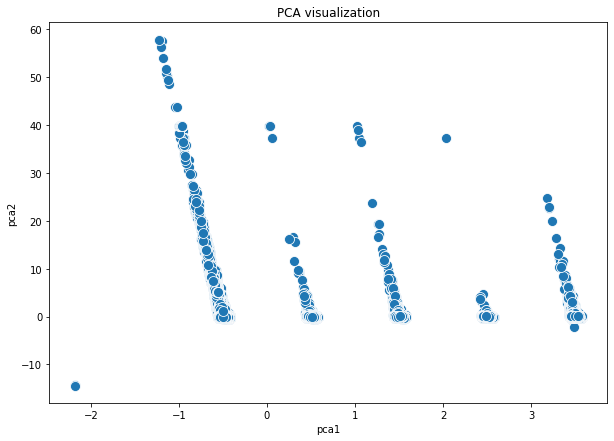

In [7]:
plot_pca_clusters(transformed_data, None)

## Reduce dimensionality to Pass to tSNE 

In [8]:
pca = PCA(n_components = 6)
pca.fit(transformed_data)

PCA(n_components=6)

In [9]:
Z = pca.transform(transformed_data)
W = pca.components_
Z.shape
W.shape

(6, 32)

In [10]:
Z = pd.DataFrame(Z).sample(1000)

## Fit and Plot tSNE

In [11]:
tsne = TSNE(random_state=42, perplexity=30)
tsne = tsne.fit_transform(Z)

<AxesSubplot:xlabel='tsne-2d-one', ylabel='tsne-2d-two'>

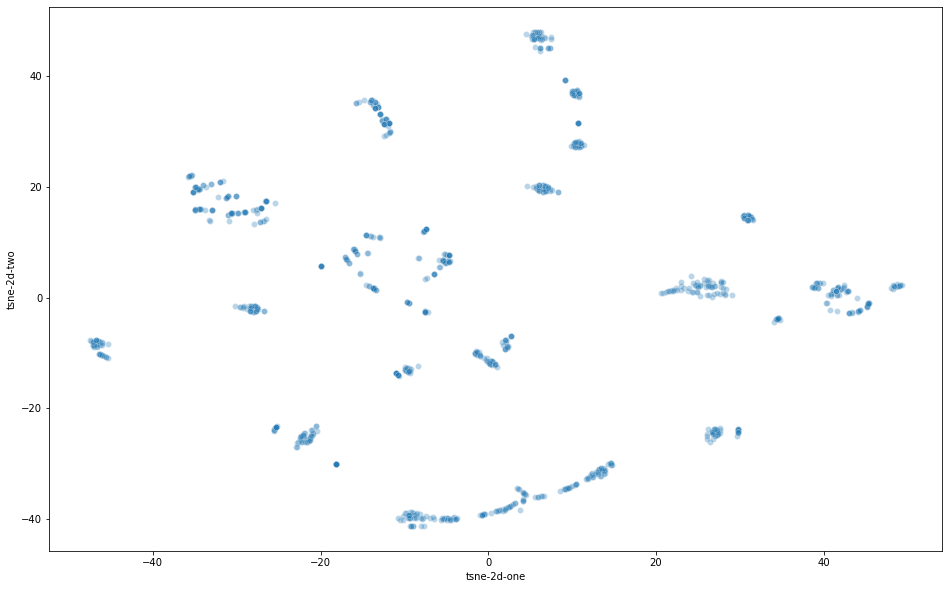

In [12]:
Z["tsne-2d-one"] = tsne[:, 0]
Z["tsne-2d-two"] = tsne[:, 1]
plt.figure(figsize=(16, 10))
sns.scatterplot(
    x="tsne-2d-one",
    y="tsne-2d-two",
    palette=sns.color_palette("hls", 10),
    data=Z,
    legend="full",
    alpha=0.3,
)